# Intro

### Motivation

Buildings are typically higher priced when new than aged buildings. We wanted to extract from data the function of the price deterioation of the buildings in Zurich over time.

### Data-Sources

- https://data.stadt-zuerich.ch/dataset/bau_hae_preis_stockwerkeigentum_zimmerzahl_stadtquartier_od5155 for BAU515OD5155.csv
- https://data.stadt-zuerich.ch/dataset/bau_hae_preis_stockwerkeigentum_zimmerzahl_gebaeudealter_od5156 for BAU515OD5156.csv
- https://data.stadt-zuerich.ch/dataset/bau_hae_preis_stockwerkeigentum_stadtquartier_od5157 for BAU515OD5157.csv
- https://data.stadt-zuerich.ch/dataset/bau_hae_preis_stockwerkeigentum_gebaeudealter_od5158 for BAU515OD5158.csv

### Decision on data normalization

By modeling the data using a star schema — with dimension tables for years, regions, room categories, age buckets, and transaction types, and a fact table for the price metrics — each dataset can be integrated consistently. 


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path

conn = sqlite3.connect("bau515.db")
cur = conn.cursor()

In [14]:
cur.executescript("""
DROP TABLE IF EXISTS base;
DROP TABLE IF EXISTS fact_age;
DROP TABLE IF EXISTS fact_room;


CREATE TABLE base (
    base_id INTEGER PRIMARY KEY,
    year INTEGER,
    anz_zimmer_cd INTEGER
);

CREATE TABLE fact_age (
    fact_age_id INTEGER PRIMARY KEY,
    base_id INTEGER,
    baualter_cd INTEGER,
    baualter_label TEXT,
    anz_ha INTEGER,
    preis_m2 REAL,
    median_preis REAL,
    sum_preis REAL,
    FOREIGN KEY(base_id) REFERENCES base(base_id)
);

CREATE TABLE fact_room (
    fact_room_id INTEGER PRIMARY KEY,
    base_id INTEGER,
    raum_cd INTEGER,
    raum_label TEXT,
    anz_ha INTEGER,
    preis_m2 REAL,
    median_preis REAL,
    sum_preis REAL,
    FOREIGN KEY(base_id) REFERENCES base(base_id)
);

""")
conn.commit()

In [15]:
folder = "raw_data"

files = [
    "bau515od5155.csv",
    "bau515od5156.csv"
]

dfs = []

for fname in files:
    path = Path(folder) / fname

    try:
        df = pd.read_csv(path)
    except:
        df = pd.read_csv(path, sep=";")

    # Drop all unwanted columns
    df = df.drop(columns=[
        "DatenstandCd", "HAArtLevel1Sort", "HAArtLevel1Cd", "HAArtLevel1Lang",
        "HASTWESort", "HASTWECd", "HASTWELang",
        "AnzZimmerLevel2Lang_noDM"
    ], errors="ignore")

    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

In [16]:
base = (
    df_all[["Stichtagdatjahr", "AnzZimmerLevel2Cd_noDM"]]
    .drop_duplicates()
    .sort_values(["Stichtagdatjahr", "AnzZimmerLevel2Cd_noDM"])
    .reset_index(drop=True)
)

base["base_id"] = base.index + 1

base = base.rename(columns={
    "Stichtagdatjahr": "year",
    "AnzZimmerLevel2Cd_noDM": "anz_zimmer_cd"
})

df_all = df_all.merge(
    base,
    left_on=["Stichtagdatjahr", "AnzZimmerLevel2Cd_noDM"],
    right_on=["year", "anz_zimmer_cd"],
    how="left"
)

fact_age = df_all[
    [
        "base_id",
        "BaualterCd_noDM",
        "BaualterLang_noDM",
        "AnzHA",
        "HAPreisWohnflaeche",
        "HAMedianPreis",
        "HASumPreis"
    ]
].dropna(subset=["BaualterCd_noDM"])

fact_age = fact_age.rename(columns={
    "BaualterCd_noDM": "baualter_cd",
    "BaualterLang_noDM": "baualter_label",
    "AnzHA": "anz_ha",
    "HAPreisWohnflaeche": "preis_m2",
    "HAMedianPreis": "median_preis",
    "HASumPreis": "sum_preis",
})

fact_room = df_all[
    [
        "base_id",
        "RaumCd",
        "RaumLang",
        "AnzHA",
        "HAPreisWohnflaeche",
        "HAMedianPreis",
        "HASumPreis"
    ]
].dropna(subset=["RaumCd"])

fact_room = fact_room.rename(columns={
    "RaumCd": "raum_cd",
    "RaumLang": "raum_label",
    "AnzHA": "anz_ha",
    "HAPreisWohnflaeche": "preis_m2",
    "HAMedianPreis": "median_preis",
    "HASumPreis": "sum_preis",
})

base.to_sql("base", conn, index=False, if_exists="replace")
fact_age.to_sql("fact_age", conn, index=False, if_exists="replace")
fact_room.to_sql("fact_room", conn, index=False, if_exists="replace")

4512

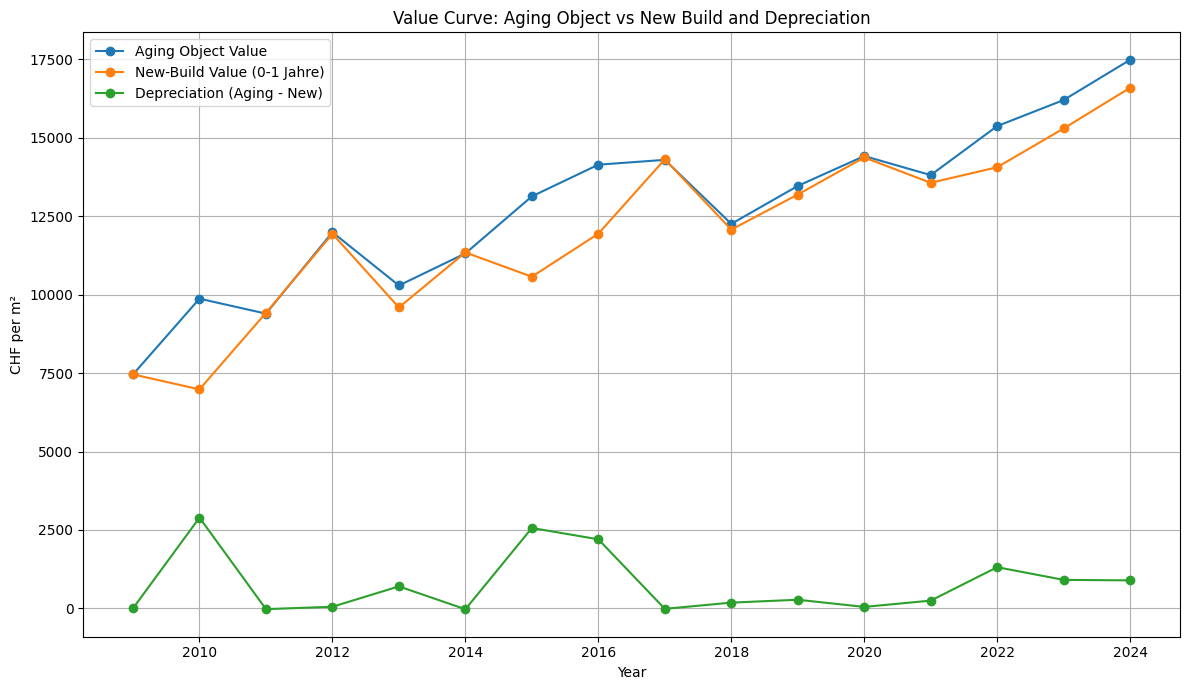

In [17]:
# -------------------------
# 1) Aging object curve
# -------------------------
q_aging = """
SELECT 
    b.year,
    AVG(a.preis_m2) AS price_aging_object
FROM fact_age a
JOIN base b ON a.base_id = b.base_id
WHERE 
    (b.year = 2009 AND a.baualter_cd = 1) OR
    (b.year BETWEEN 2010 AND 2018 AND a.baualter_cd = 2) OR
    (b.year >= 2019 AND a.baualter_cd = 3)
GROUP BY b.year
ORDER BY b.year;
"""

aging = pd.read_sql_query(q_aging, conn)


# -------------------------
# 2) New-build curve (0–1 Jahre)
# -------------------------
q_new = """
SELECT 
    b.year,
    AVG(a.preis_m2) AS price_new_build
FROM fact_age a
JOIN base b ON a.base_id = b.base_id
WHERE a.baualter_cd = 1   -- 0-1 years
GROUP BY b.year
ORDER BY b.year;
"""

newbuild = pd.read_sql_query(q_new, conn)


# -------------------------
# 3) Merge + difference curve
# -------------------------
df = aging.merge(newbuild, on="year", how="left")
df["depreciation"] = df["price_aging_object"] - df["price_new_build"]


# -------------------------
# 4) Plot all three curves
# -------------------------
plt.figure(figsize=(12, 7))

plt.plot(df["year"], df["price_aging_object"], marker="o", label="Aging Object Value")
plt.plot(df["year"], df["price_new_build"], marker="o", label="New-Build Value (0-1 Jahre)")
plt.plot(df["year"], df["depreciation"], marker="o", label="Depreciation (Aging - New)")

plt.xlabel("Year")
plt.ylabel("CHF per m²")
plt.title("Value Curve: Aging Object vs New Build and Depreciation")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

🏆 District performance ranking (2009 → latest):


district
Lindenhof               30112.000000
Hard                    18208.750000
Kreis 4                 15053.000000
Alt-Wiedikon            14653.100000
Kreis 8                 12384.250000
Langstrasse             12325.666667
Kreis 3                 12215.400000
Hirslanden              12025.750000
Sihlfeld                11219.400000
Enge                    11077.666667
Weinegg                 10123.750000
City                     9979.000000
Mühlebach                9482.666667
Schwamendingen-Mitte     9467.700000
Oberstrass               9338.800000
Seebach                  9247.400000
Altstetten               9188.333333
Kreis 12                 9140.800000
Oerlikon                 9005.750000
Witikon                  8917.966667
Kreis 11                 8633.733333
Unterstrass              8576.500000
Ganze Stadt              8527.833333
Kreis 2                  8113.500000
Kreis 9                  8078.400000
Höngg                    7395.900000
Affoltern                7372

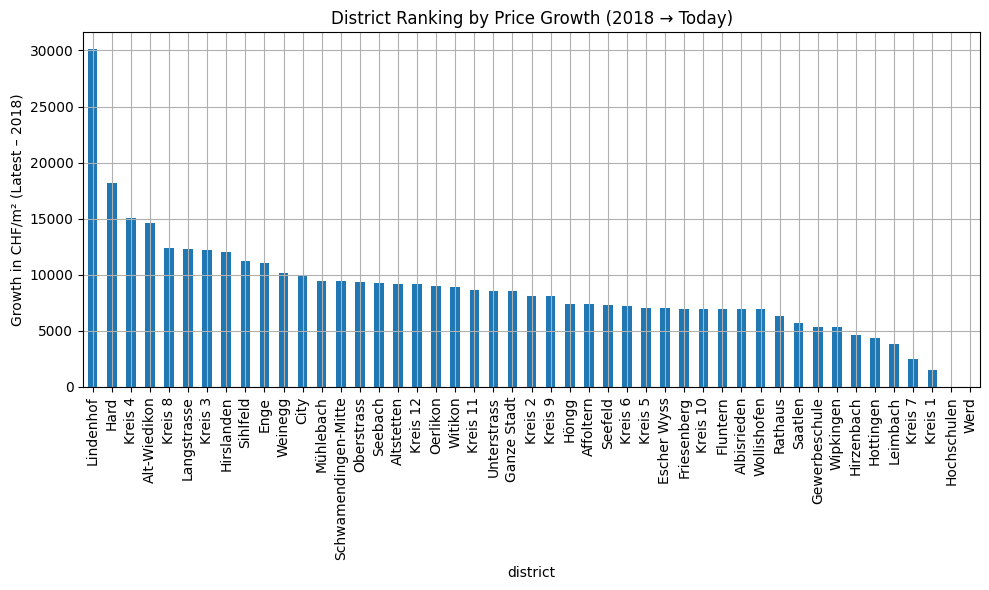

In [18]:
# -----------------------------------------
# 1) SQL: price development per district, from 2018 onward
# -----------------------------------------
query = """
SELECT 
    b.year,
    r.raum_label AS district,
    AVG(r.preis_m2) AS avg_price_m2
FROM fact_room r
JOIN base b ON r.base_id = b.base_id
WHERE 
    r.raum_label IS NOT NULL
GROUP BY b.year, r.raum_label
ORDER BY r.raum_label, b.year;
"""

df = pd.read_sql_query(query, conn)

# -----------------------------------------
# 2) Pivot for ranking and plotting
# -----------------------------------------
pivot = df.pivot(index="year", columns="district", values="avg_price_m2")

# Ranking: compute growth from 2018 to newest year
ranking = pivot.iloc[-1] - pivot.iloc[0]
ranking = ranking.sort_values(ascending=False)

print("🏆 District performance ranking (2009 → latest):")
display(ranking)

# -----------------------------------------
# 4) Bar chart: ranking
# -----------------------------------------
plt.figure(figsize=(10,6))
ranking.plot(kind="bar")
plt.title("District Ranking by Price Growth (2018 → Today)")
plt.ylabel("Growth in CHF/m² (Latest – 2018)")
plt.grid(True)
plt.tight_layout()
plt.show()